In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
from bitlinear158 import BitLinear158, BitLinear158Inference

In [2]:
def generate_gaussian_data(n_samples=1000, mean=[0, 0], cov=[[1, 0],[0, 1]]):
    data = np.random.multivariate_normal(mean, cov, n_samples)
    return torch.tensor(data, dtype=torch.float32)


In [3]:
# data = torch.vstack((generate_gaussian_data(cov=[[1, 1],[1, 1]]), generate_gaussian_data(cov=[[1,-1],[-1,1]])))
data = generate_gaussian_data()


In [4]:
# np.random.shuffle(data.numpy())

In [5]:
device='cpu'

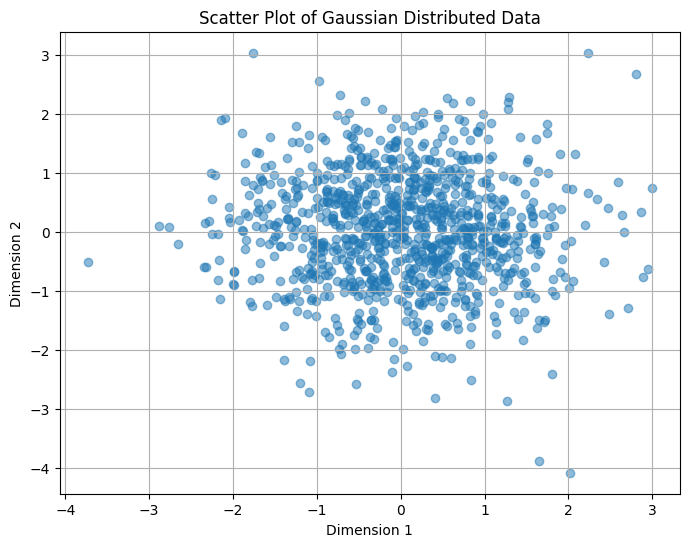

In [6]:
def plot_data(data):
    """Plot 2D data using a scatter plot."""
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], alpha=0.5)
    plt.title('Scatter Plot of Gaussian Distributed Data')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()

plot_data(data)


In [7]:
class VAE(nn.Module):
    def __init__(self, input_dim=2, latent_dim=2, device = device):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.fc1 = BitLinear158(input_dim, 50)
        # self.fc2 = BitLinear158(50, 50)
        self.fc31 = BitLinear158(50, latent_dim)  # For mu
        self.fc32 = BitLinear158(50, latent_dim)  # For log variance

        # Decoder
        self.fc3 = BitLinear158(latent_dim, 50)
        # self.fc4 = BitLinear158(50, 50)
        self.fc5 = BitLinear158(50, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        # h2 = F.relu(self.fc2(h1))
        return self.fc31(h1), self.fc32(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar).to(device)
        eps = torch.randn_like(std).to(device)
        mu.to(device)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        # h4 = F.relu(self.fc4(h3))
        return self.fc5(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def encode_latent(self, x):
        with torch.no_grad():
            mu, _ = self.encode(x)
            return mu

In [8]:
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction="sum")
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KL

In [9]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
data_loader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=True)


In [10]:
for epoch in range(100):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(data_loader):
        optimizer.zero_grad()
        data.to(device)
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        
    print(
        f"Train Epoch: {epoch}  Loss: {loss.item() / len(data):.6f}"
    )


/home/titi/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train Epoch: 0  Loss: 1.478207
Train Epoch: 1  Loss: 1.506215
Train Epoch: 2  Loss: 2.284300
Train Epoch: 3  Loss: 1.539731
Train Epoch: 4  Loss: 1.776783
Train Epoch: 5  Loss: 2.387986
Train Epoch: 6  Loss: 1.632656
Train Epoch: 7  Loss: 2.057107
Train Epoch: 8  Loss: 1.942143
Train Epoch: 9  Loss: 2.011617
Train Epoch: 10  Loss: 1.888389
Train Epoch: 11  Loss: 1.769603
Train Epoch: 12  Loss: 2.161768
Train Epoch: 13  Loss: 2.180085
Train Epoch: 14  Loss: 1.595559
Train Epoch: 15  Loss: 1.372044
Train Epoch: 16  Loss: 1.613653
Train Epoch: 17  Loss: 1.365508
Train Epoch: 18  Loss: 1.981911
Train Epoch: 19  Loss: 1.670393
Train Epoch: 20  Loss: 1.675117
Train Epoch: 21  Loss: 1.767047
Train Epoch: 22  Loss: 1.809370
Train Epoch: 23  Loss: 1.403819
Train Epoch: 24  Loss: 1.438003
Train Epoch: 25  Loss: 1.625704
Train Epoch: 26  Loss: 1.805269
Train Epoch: 27  Loss: 1.692663
Train Epoch: 28  Loss: 1.921596
Train Epoch: 29  Loss: 1.410315
Train Epoch: 30  Loss: 1.481045
Train Epoch: 31  L

In [11]:
latent_variables = []
for data in data_loader:
    mu = model.encode_latent(data)
    latent_variables.append(mu)
latent_variables = torch.cat(latent_variables, 0)


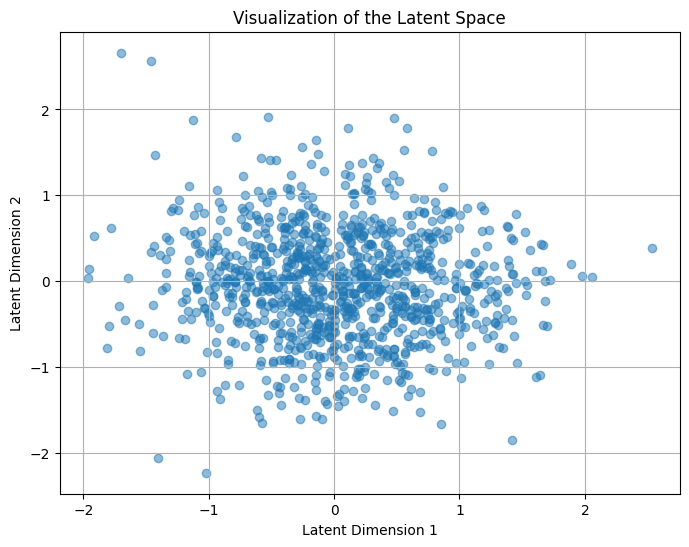

In [12]:

x, y = latent_variables[:, 0].numpy(), latent_variables[:, 1].numpy()

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Visualization of the Latent Space')
plt.grid(True)
plt.show()

In [13]:
print(model)

VAE(
  (fc1): BitLinear158(in_features=2, out_features=50, bias=True)
  (fc31): BitLinear158(in_features=50, out_features=2, bias=True)
  (fc32): BitLinear158(in_features=50, out_features=2, bias=True)
  (fc3): BitLinear158(in_features=2, out_features=50, bias=True)
  (fc5): BitLinear158(in_features=50, out_features=2, bias=True)
)


In [14]:
model.fc31.weight

Parameter containing:
tensor([[ 0.1844, -0.0647, -0.2896, -0.0336, -0.0572,  0.0161,  0.0651, -0.2781,
         -0.1681,  0.1446,  0.2103, -0.0170,  0.0661,  0.0257,  0.0641,  0.4006,
          0.0276, -0.2294,  0.1622, -0.2389, -0.1326, -0.0639,  0.0473, -0.0809,
         -0.0605, -0.0052,  0.1038,  0.2308, -0.2756,  0.0030,  0.0151,  0.1634,
         -0.2391,  0.2276, -0.0642, -0.0478,  0.0598, -0.2613, -0.0460, -0.0650,
          0.0637,  0.2892, -0.1513,  0.0904, -0.0723, -0.0210, -0.1038,  0.1487,
          0.1499, -0.0644],
        [-0.0426,  0.0644,  0.0955, -0.2348, -0.0702, -0.0701, -0.3008, -0.2436,
          0.3540, -0.2514,  0.2169,  0.0589,  0.0024, -0.0422, -0.1111, -0.1993,
          0.0613,  0.2799,  0.2219, -0.1471, -0.1810, -0.2407,  0.0629, -0.1290,
          0.0523,  0.0566,  0.0569,  0.0050, -0.1353,  0.0334, -0.1030, -0.2285,
         -0.0877, -0.0652,  0.0852,  0.3619,  0.1346,  0.3106, -0.0865,  0.1794,
         -0.0642,  0.0919, -0.1353,  0.0687,  0.0870, -0.02

In [15]:
def change_to_inference(model):
    
    bitlinear_layers  = [(k, m) for k, m in model.named_modules() if type(m).__name__ == 'BitLinear158'] 
    for name, layer in bitlinear_layers:
        layer.beta = 1 / layer.weight.abs().mean().clamp(min=1e-5)
        layer.weight = nn.Parameter((layer.weight * layer.beta).round().clamp(-1, 1))
        layer.weight.detach()
        layer.weight.requires_grad = False
        new_layer = BitLinear158Inference(layer.input_dim, layer.output_dim)  
        new_layer.weight.data = layer.weight.data.clone()
        setattr(model, name, new_layer)

change_to_inference(model)


In [16]:
bitlinear_layers  = [(k, m) for k, m in model.named_modules() if type(m).__name__ == 'BitLinear158']

In [17]:
print(model)

VAE(
  (fc1): BitLinear158Inference(in_features=2, out_features=50, bias=True)
  (fc31): BitLinear158Inference(in_features=50, out_features=2, bias=True)
  (fc32): BitLinear158Inference(in_features=50, out_features=2, bias=True)
  (fc3): BitLinear158Inference(in_features=2, out_features=50, bias=True)
  (fc5): BitLinear158Inference(in_features=50, out_features=2, bias=True)
)


In [18]:
model.fc31.weight

Parameter containing:
tensor([[ 1., -1., -1., -0., -0.,  0.,  1., -1., -1.,  1.,  1., -0.,  1.,  0.,
          0.,  1.,  0., -1.,  1., -1., -1., -0.,  0., -1., -0., -0.,  1.,  1.,
         -1.,  0.,  0.,  1., -1.,  1., -0., -0.,  0., -1., -0., -1.,  0.,  1.,
         -1.,  1., -1., -0., -1.,  1.,  1., -0.],
        [-0.,  0.,  1., -1., -1., -1., -1., -1.,  1., -1.,  1.,  0.,  0., -0.,
         -1., -1.,  0.,  1.,  1., -1., -1., -1.,  0., -1.,  0.,  0.,  0.,  0.,
         -1.,  0., -1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,  1., -0.,  1.,
         -1.,  1.,  1., -0.,  1.,  0.,  1.,  1.]], requires_grad=True)

In [19]:
def sample_from_vae(model, n_samples=100, device='cpu'):
    model.eval()
    with torch.no_grad():
        # Sample from a standard normal distribution
        z = torch.randn(n_samples, model.latent_dim).to(device) 
        # Decode the sample
        sampled_data = model.decode(z)
    return sampled_data


In [20]:
n_samples =500
generated_data = sample_from_vae(model, n_samples=n_samples, device='cpu')

generated_data = generated_data.cpu().numpy()


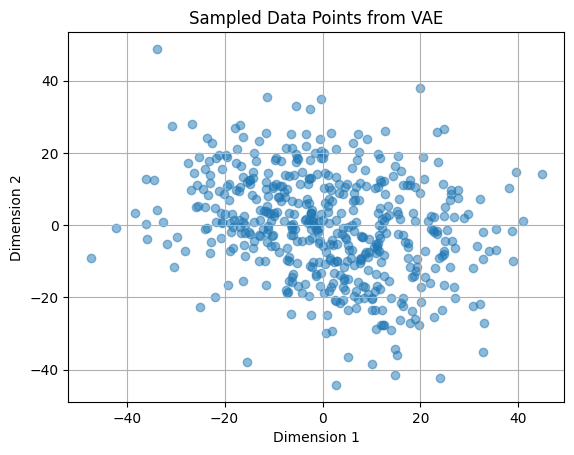

In [21]:
plt.scatter(generated_data[:, 0], generated_data[:, 1], alpha=0.5)
plt.title("Sampled Data Points from VAE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()
